# Block 1: Install Dependencies

In [ ]:
!pip install -q "numpy<2.0" opencv-python-headless==4.8.1.78 timm albumentations PyYAML einops

# Block 2: Create Project Directories

In [ ]:
import os

PROJECT_ROOT = '/kaggle/working/camoXpert'
DIRS = [
    'configs',
    'data',
    'losses',
    'metrics',
    'models',
    'scripts',
    'results/checkpoints'
]

# Create all directories
for d in DIRS:
    os.makedirs(os.path.join(PROJECT_ROOT, d), exist_ok=True)

# Create __init__.py files to make them packages
INIT_DIRS = ['data', 'losses', 'metrics', 'models']
for d in INIT_DIRS:
    with open(os.path.join(PROJECT_ROOT, d, '__init__.py'), 'w') as f:
        pass

print("Project directories created successfully.")

# Block 3: Write Config Files

In [ ]:
%%writefile /kaggle/working/camoXpert/configs/config.yaml
# --- General Config ---
seed: 42

# --- Device Config ---
device:
  num_workers: 2
  pin_memory: True
  mixed_precision: True

# --- Dataset Config ---
dataset:
  num_classes: 1

In [ ]:
%%writefile /kaggle/working/camoXpert/configs/hyperparameters.yaml
# --- Hyperparameters ---
optimizer:
  learning_rate: 1.0e-4
  weight_decay: 0.01

scheduler:
  type: 'CosineAnnealingWarmRestarts'
  t_0: 10
  t_mult: 2

loss_weights:
  bce: 1.0
  dice: 1.0
  structure: 0.5
  aux: 0.1

# Block 4: Write Data Pipeline Files

In [ ]:
%%writefile /kaggle/working/camoXpert/data/augmentations.py
import albumentations as A
from albumentations.pytorch import ToTensorV2

class AdvancedCODAugmentation:
    def __init__(self, img_size=352, is_train=True):
        self.img_size = img_size
        self.is_train = is_train

        if self.is_train:
            self.transform = A.Compose([
                A.Resize(img_size, img_size),
                A.HorizontalFlip(p=0.5),
                A.VerticalFlip(p=0.5),
                A.RandomRotate90(p=0.5),
                A.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.1, p=0.7),
                A.GaussianBlur(blur_limit=(3, 7), p=0.3),
                A.Normalize(
                    mean=[0.485, 0.456, 0.406],
                    std=[0.229, 0.224, 0.225],
                ),
                ToTensorV2(),
            ], p=1.0, is_check_shapes=False) # <-- FIX ADDED
        else:
            self.transform = A.Compose([
                A.Resize(img_size, img_size),
                A.Normalize(
                    mean=[0.485, 0.456, 0.406],
                    std=[0.229, 0.224, 0.225],
                ),
                ToTensorV2(),
            ], p=1.0, is_check_shapes=False) # <-- FIX ADDED

    def __call__(self, image, mask):
        return self.transform(image=image, mask=mask)

In [ ]:
%%writefile /kaggle/working/camoXpert/data/dataset.py
import os
import cv2
import numpy as np
import torch
from torch.utils.data import Dataset
from .augmentations import AdvancedCODAugmentation

class CODDataset(Dataset):
    def __init__(self, root_dir, dataset_name='COD10K', split='train', img_size=352, augment=True, debug_len=None):
        self.root_dir = root_dir
        self.dataset_name = dataset_name
        self.split = split
        self.img_size = img_size
        self.augment = augment and split == 'train'

        print(f"Loading dataset: {dataset_name} ({split})")
        
        if split == 'train':
            self.image_dir = os.path.join(root_dir, 'Train', 'Image')
            self.mask_dir = os.path.join(root_dir, 'Train', 'GT_Object')
        else:
            self.image_dir = os.path.join(root_dir, 'Test', 'Image')
            self.mask_dir = os.path.join(root_dir, 'Test', 'GT_Object')
       
        if not os.path.isdir(self.image_dir):
            raise FileNotFoundError(f"Image directory not found: {self.image_dir}")

        self.image_list = sorted([f for f in os.listdir(self.image_dir) if f.endswith(('.jpg', '.png', '.jpeg'))])
        
        if debug_len is not None:
            self.image_list = self.image_list[:debug_len]

        self.transform = AdvancedCODAugmentation(img_size=img_size, is_train=self.augment)
        print(f"Found {len(self.image_list)} images in {self.image_dir}")

    def __len__(self):
        return len(self.image_list)

    def __getitem__(self, idx):
        img_name = self.image_list[idx]
        img_path = os.path.join(self.image_dir, img_name)

        image = cv2.imread(img_path)
        if image is None:
            raise IOError(f"Could not read image: {img_path}")
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        mask_extensions = ['.png', '.jpg', '.jpeg', '.PNG', '.JPG']
        base_name = os.path.splitext(img_name)[0]

        mask = None
        for ext in mask_extensions:
            mask_name_try = base_name + ext
            if os.path.exists(os.path.join(self.mask_dir, mask_name_try)):
                mask_path = os.path.join(self.mask_dir, mask_name_try)
                mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
                break
        
        if mask is None:
             mask_path = os.path.join(self.mask_dir, img_name)
             if os.path.exists(mask_path):
                 mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
             else:
                raise ValueError(f"Failed to load mask for: {img_name} at {self.mask_dir}")
        
        if mask is None:
            raise IOError(f"Could not read mask for image: {img_name}")

        mask = (mask > 128).astype(np.float32)
        transformed = self.transform(image=image, mask=mask)
        image_tensor = transformed['image']
        mask_tensor = transformed['mask']

        return image_tensor, mask_tensor.unsqueeze(0)

# Block 5: Write Loss Functions

In [ ]:
%%writefile /kaggle/working/camoXpert/losses/dice_loss.py
import torch
import torch.nn as nn
import torch.nn.functional as F

class DiceLoss(nn.Module):
    def __init__(self, smooth=1e-5):
        super(DiceLoss, self).__init__()
        self.smooth = smooth
    def forward(self, pred, target):
        pred_sig = torch.sigmoid(pred)
        intersection = (pred_sig * target).sum(dim=(2, 3))
        union = pred_sig.sum(dim=(2, 3)) + target.sum(dim=(2, 3))
        dice = (2. * intersection + self.smooth) / (union + self.smooth)
        return 1.0 - dice.mean()

In [ ]:
%%writefile /kaggle/working/camoXpert/losses/structure_loss.py
import torch
import torch.nn as nn
import torch.nn.functional as F

class StructureLoss(nn.Module):
    def __init__(self):
        super(StructureLoss, self).__init__()
        self.criterion = nn.L1Loss()
    def forward(self, pred, target):
        pred_sig = torch.sigmoid(pred)
        target = target.float()
        
        # Sobel operator for edge detection
        weight_x = torch.tensor([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]], dtype=torch.float32).view(1, 1, 3, 3).to(pred.device)
        weight_y = torch.tensor([[-1, -2, -1], [0, 0, 0], [1, 2, 1]], dtype=torch.float32).view(1, 1, 3, 3).to(pred.device)
        
        pred_edge_x = F.conv2d(pred_sig, weight_x, padding=1)
        pred_edge_y = F.conv2d(pred_sig, weight_y, padding=1)
        pred_edge = torch.abs(pred_edge_x) + torch.abs(pred_edge_y)
        
        target_edge_x = F.conv2d(target, weight_x, padding=1)
        target_edge_y = F.conv2d(target, weight_y, padding=1)
        target_edge = torch.abs(target_edge_x) + torch.abs(target_edge_y)
        
        return self.criterion(pred_edge, target_edge)

In [ ]:
%%writefile /kaggle/working/camoXpert/losses/advanced_loss.py
import torch
import torch.nn as nn
from .dice_loss import DiceLoss
from .structure_loss import StructureLoss

class AdvancedCODLoss(nn.Module):
    def __init__(self, bce_weight=1.0, iou_weight=1.0, edge_weight=0.5, aux_weight=0.1):
        super(AdvancedCODLoss, self).__init__()
        self.bce = nn.BCEWithLogitsLoss()
        self.dice = DiceLoss()
        self.edge = StructureLoss()
        self.bce_weight = bce_weight
        self.iou_weight = iou_weight
        self.edge_weight = edge_weight
        self.aux_weight = aux_weight

    def forward(self, pred, target, aux_loss=None, deep_outputs=None):
        bce = self.bce(pred, target)
        iou = self.dice(pred, target)
        edge = self.edge(pred, target)
        total_loss = (self.bce_weight * bce + self.iou_weight * iou + self.edge_weight * edge)
        loss_dict = {'bce': bce.item(), 'iou': iou.item(), 'edge': edge.item()}

        # This will be a DataParallel-gathered tensor [N]
        if aux_loss is not None:
            if aux_loss.dim() > 0:
                aux_loss = aux_loss.mean()
            total_loss += self.aux_weight * aux_loss
            loss_dict['aux'] = aux_loss.item()

        if deep_outputs is not None:
            deep_loss = 0
            for i, deep_pred in enumerate(deep_outputs):
                deep_loss += self.bce(deep_pred, target)
            deep_loss /= len(deep_outputs)
            total_loss += 0.4 * deep_loss
            loss_dict['deep'] = deep_loss.item()
        
        loss_dict['total'] = total_loss.item()
        return total_loss, loss_dict

# Block 6: Write Metrics File

In [ ]:
%%writefile /kaggle/working/camoXpert/metrics/cod_metrics.py
import torch

class CODMetrics:
    def __init__(self, device, smooth=1e-5):
        self.device = device
        self.smooth = smooth

    def compute_all(self, pred, target):
        pred_sig = torch.sigmoid(pred)
        pred_bin = (pred_sig > 0.5).float()
        target = target.float()
        
        intersection = (pred_bin * target).sum()
        union = pred_bin.sum() + target.sum()
        
        # IoU (Jaccard)
        iou = (intersection + self.smooth) / (union - intersection + self.smooth)
        
        # Dice
        dice = (2. * intersection + self.smooth) / (union + self.smooth)
        
        return {
            'IoU': iou.item(),
            'Dice_Score': dice.item()
        }

# Block 7: Write Model Utilities

In [ ]:
%%writefile /kaggle/working/camoXpert/models/utils.py
import torch
import random
import numpy as np
import yaml
import os

class AverageMeter:
    def __init__(self):
        self.reset()
    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0
    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

def count_parameters(model):
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    return total_params, trainable_params

def load_config(path):
    with open(path, 'r') as f:
        return yaml.safe_load(f)

def save_checkpoint(state, save_dir, filename='checkpoint.pth'):
    os.makedirs(save_dir, exist_ok=True)
    torch.save(state, os.path.join(save_dir, filename))
    print(f"\n✓ Checkpoint saved at {os.path.join(save_dir, filename)}")

In [ ]:
%%writefile /kaggle/working/camoXpert/models/fusion.py
import torch
import torch.nn as nn
import torch.nn.functional as F
from .backbone import LayerNorm2d
from einops import rearrange

class ConvBlock(nn.Module):
    def __init__(self, in_dim, out_dim, kernel_size=3, padding=1, stride=1, dilation=1):
        super().__init__()
        self.conv = nn.Conv2d(in_dim, out_dim, kernel_size, stride, padding, dilation=dilation, bias=False)
        self.norm = LayerNorm2d(out_dim)
        self.act = nn.GELU()
    def forward(self, x):
        return self.act(self.norm(self.conv(x)))

class CrossAttention(nn.Module):
    def __init__(self, in_dim, num_heads=8, qkv_bias=True, scale=None):
        super().__init__()
        self.num_heads = num_heads
        head_dim = in_dim // num_heads
        self.scale = scale or head_dim ** -0.5
        self.q_conv = nn.Conv2d(in_dim, in_dim, 1, bias=qkv_bias)
        self.k_conv = nn.Conv2d(in_dim, in_dim, 1, bias=qkv_bias)
        self.v_conv = nn.Conv2d(in_dim, in_dim, 1, bias=qkv_bias)
        self.proj = nn.Conv2d(in_dim, in_dim, 1)

    def forward(self, x, y):
        B, C, H, W = x.shape
        q = self.q_conv(x).flatten(2).transpose(1, 2)
        k = self.k_conv(y).flatten(2).transpose(1, 2)
        v = self.v_conv(y).flatten(2).transpose(1, 2)
        
        q = rearrange(q, 'b n (h d) -> b h n d', h=self.num_heads)
        k = rearrange(k, 'b n (h d) -> b h n d', h=self.num_heads)
        v = rearrange(v, 'b n (h d) -> b h n d', h=self.num_heads)

        attn = (q @ k.transpose(-2, -1)) * self.scale
        attn = attn.softmax(dim=-1)
        
        out = (attn @ v)
        out = rearrange(out, 'b h n d -> b n (h d)')
        out = out.transpose(1, 2).reshape(B, C, H, W)
        return self.proj(out) + x

class FeatureFusion(nn.Module):
    def __init__(self, dim, num_heads=8):
        super().__init__()
        self.cross_attn = CrossAttention(dim, num_heads)
        self.conv_block = ConvBlock(dim, dim)
    def forward(self, high_feat, low_feat):
        low_feat_upsampled = F.interpolate(low_feat, size=high_feat.shape[2:], mode='bilinear', align_corners=True)
        fused_feat = self.cross_attn(high_feat, low_feat_upsampled)
        return self.conv_block(fused_feat)

In [ ]:
%%writefile /kaggle/working/camoXpert/models/segmentation_head.py
import torch
import torch.nn as nn
import torch.nn.functional as F
from .backbone import LayerNorm2d
from einops import rearrange

class ConvBlock(nn.Module):
    def __init__(self, in_dim, out_dim, kernel_size=3, padding=1, stride=1, dilation=1):
        super().__init__()
        self.conv = nn.Conv2d(in_dim, out_dim, kernel_size, stride, padding, dilation=dilation, bias=False)
        self.norm = LayerNorm2d(out_dim)
        self.act = nn.GELU()
    def forward(self, x):
        return self.act(self.norm(self.conv(x)))

class Decoder(nn.Module):
    def __init__(self, encoder_dims, decoder_dims):
        super().__init__()
        self.conv_blocks = nn.ModuleList()
        for i in range(len(decoder_dims)):
            if i == 0:
                in_c = encoder_dims[-1]
            else:
                in_c = decoder_dims[i-1] + encoder_dims[-(i+1)]
            out_c = decoder_dims[i]
            self.conv_blocks.append(ConvBlock(in_c, out_c))
            
    def forward(self, features):
        x = self.conv_blocks[0](features[-1])
        decoded_features = [x]
        
        for i in range(1, len(self.conv_blocks)):
            x = F.interpolate(x, size=features[-(i+1)].shape[2:], mode='bilinear', align_corners=True)
            x = torch.cat([x, features[-(i+1)]], dim=1)
            x = self.conv_blocks[i](x)
            decoded_features.append(x)
            
        return decoded_features

class SegmentationHead(nn.Module):
    def __init__(self, in_dim, mid_dim, out_dim, num_classes, deep_supervision=True):
        super().__init__()
        self.deep_supervision = deep_supervision
        self.conv_in = ConvBlock(in_dim, mid_dim)
        self.conv_out = nn.Conv2d(mid_dim, num_classes, 1)
        if self.deep_supervision:
            self.deep_head_3 = nn.Conv2d(out_dim[1], num_classes, 1)
            self.deep_head_2 = nn.Conv2d(out_dim[2], num_classes, 1)

    def forward(self, features, deep_features=None):
        x = self.conv_in(features)
        x = self.conv_out(x)
        
        if self.training and self.deep_supervision and deep_features is not None:
            out_3 = self.deep_head_3(deep_features[1])
            out_2 = self.deep_head_2(deep_features[2])
            return x, [out_3, out_2]
            
        return x, []

# Block 8: Write Model Backbones (SDTA & Experts)

In [ ]:
%%writefile /kaggle/working/camoXpert/models/backbone.py
import torch
import torch.nn as nn
import torch.nn.functional as F
from timm.models.layers import DropPath, trunc_normal_
from einops import rearrange

class LayerNorm2d(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.norm = nn.LayerNorm(dim, eps=1e-6)
    def forward(self, x):
        x = rearrange(x, 'b c h w -> b h w c').contiguous()
        x = self.norm(x)
        return rearrange(x, 'b h w c -> b c h w').contiguous()

class SDTAEncoder(nn.Module):
    def __init__(self, in_dim, num_heads=8, qkv_bias=True, scale=None, drop_path=0.):
        super().__init__()
        self.num_heads = num_heads
        head_dim = in_dim // num_heads
        self.scale = scale or head_dim ** -0.5

        self.q_conv = nn.Conv2d(in_dim, in_dim, 1, bias=qkv_bias)
        self.k_conv = nn.Conv2d(in_dim, in_dim, 1, bias=qkv_bias)
        self.v_conv = nn.Conv2d(in_dim, in_dim, 1, bias=qkv_bias)
        self.proj = nn.Conv2d(in_dim, in_dim, 1)
        self.drop_path = DropPath(drop_path) if drop_path > 0. else nn.Identity()

    def forward(self, x):
        B, C, H, W = x.shape
        q = self.q_conv(x).flatten(2).transpose(1, 2)
        k = self.k_conv(x).flatten(2).transpose(1, 2)
        v = self.v_conv(x).flatten(2).transpose(1, 2)
        
        q = rearrange(q, 'b n (h d) -> b h n d', h=self.num_heads)
        k = rearrange(k, 'b n (h d) -> b h n d', h=self.num_heads)
        v = rearrange(v, 'b n (h d) -> b h n d', h=self.num_heads)

        attn = (q @ k.transpose(-2, -1)) * self.scale
        attn = attn.softmax(dim=-1)
        
        out = (attn @ v)
        out = rearrange(out, 'b h n d -> b n (h d)')
        out = out.transpose(1, 2).reshape(B, C, H, W)
        return x + self.drop_path(self.proj(out))

In [ ]:
%%writefile /kaggle/working/camoXpert/models/experts.py
import torch
import torch.nn as nn
import torch.nn.functional as F
from .backbone import LayerNorm2d
from einops import rearrange

class ConvBlock(nn.Module):
    def __init__(self, in_dim, out_dim, kernel_size=3, padding=1, stride=1, dilation=1):
        super().__init__()
        self.conv = nn.Conv2d(in_dim, out_dim, kernel_size, stride, padding, dilation=dilation, bias=False)
        self.norm = LayerNorm2d(out_dim)
        self.act = nn.GELU()
    def forward(self, x):
        return self.act(self.norm(self.conv(x)))

class TextureExpert(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.branch1 = ConvBlock(dim, dim // 4, kernel_size=1, padding=0)
        self.branch2 = ConvBlock(dim, dim // 4, kernel_size=3, padding=2, dilation=2)
        self.branch3 = ConvBlock(dim, dim // 4, kernel_size=3, padding=4, dilation=4)
        self.branch4 = ConvBlock(dim, dim // 4, kernel_size=3, padding=6, dilation=6)
        self.out_conv = ConvBlock(dim, dim, kernel_size=1, padding=0)
    def forward(self, x):
        b1, b2, b3, b4 = self.branch1(x), self.branch2(x), self.branch3(x), self.branch4(x)
        out = torch.cat([b1, b2, b3, b4], dim=1)
        return self.out_conv(out)

class BoundaryExpert(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.conv_a = ConvBlock(dim, dim, kernel_size=3)
        self.conv_b = ConvBlock(dim, dim, kernel_size=3)
    def forward(self, x):
        return self.conv_b(self.conv_a(x))

class ContrastExpert(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.pool = nn.AdaptiveAvgPool2d(1)
        self.fc1 = nn.Linear(dim, dim // 4)
        self.act = nn.GELU()
        self.fc2 = nn.Linear(dim // 4, dim)
        self.sigmoid = nn.Sigmoid()
    def forward(self, x):
        b, c, _, _ = x.shape
        pooled_features = self.pool(x).view(b, c)
        scores = self.sigmoid(self.fc2(self.act(self.fc1(pooled_features))))
        return x * scores.view(b, c, 1, 1)

class MoERouter(nn.Module):
    def __init__(self, in_dim, num_experts, top_k=2):
        super().__init__()
        self.num_experts = num_experts
        self.top_k = top_k
        self.gate = nn.Linear(in_dim, num_experts)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x_flat = x.mean(dim=(2, 3))
        logits = self.gate(x_flat)
        weights, indices = torch.topk(logits, self.top_k, dim=1)
        weights = self.softmax(weights)
        
        logits_soft = self.softmax(logits)
        expert_counts = logits_soft.sum(dim=0)
        aux_loss = (expert_counts * (expert_counts.log() + 1e-8)).mean()
        
        return weights, indices, aux_loss

class MoELayer(nn.Module):
    def __init__(self, in_dim, num_experts=3, top_k=2):
        super().__init__()
        self.router = MoERouter(in_dim, num_experts, top_k)
        self.top_k = top_k
        self.num_experts = num_experts
        
        self.experts = nn.ModuleList([
            TextureExpert(in_dim),
            BoundaryExpert(in_dim),
            ContrastExpert(in_dim)
        ])
        
        assert len(self.experts) == self.num_experts, "Expert count mismatch"

    def forward(self, x):
        b, c, h, w = x.shape
        weights, indices, aux_loss = self.router(x)
        output = torch.zeros_like(x)
        for i in range(b):
            top_indices, top_weights = indices[i], weights[i]
            for j in range(self.top_k):
                # --- This .item() call is the one that ---
                # --- caused our multi-GPU crash, but ---
                # --- is 100% safe in our new validate() ---
                expert_idx = top_indices[j].item()
                expert_weight = top_weights[j]
                output[i] += expert_weight * self.experts[expert_idx](x[i].unsqueeze(0)).squeeze(0)
        return output, aux_loss

# Block 9: Write the Main Model

In [ ]:
%%writefile /kaggle/working/camoXpert/models/camoxpert.py
import torch
import torch.nn as nn
import torch.nn.functional as F
from timm.models import create_model
from .experts import MoELayer
from .fusion import FeatureFusion
from .segmentation_head import Decoder, SegmentationHead
from .sinet_encoder import SINetEncoder # <-- IMPORTING RES2NET

# --- This is now a HYBRID model registry ---
BACKBONE_REGISTRY = {
    'edgenext_small': 'edgenext_small',
    'res2net_ncd': SINetEncoder  # <-- ADDED RES2NET
}

class CamoXpert(nn.Module):
    def __init__(self, num_classes=1, backbone='edgenext_small', num_experts=3, top_k=2, pretrained=True):
        super(CamoXpert, self).__init__()
        
        print("\n" + "="*70)
        print(f"INITIALIZING CAMOXPERT (OPTIMIZED HYBRID - NO SDTA)")
        print("="*70)
        print(f"Backbone: {backbone}, Pretrained: {pretrained}, Experts: {num_experts}")

        self.backbone_name = backbone
        self.deep_supervision = True

        # --- 1. Load the Backbone ---
        if backbone == 'res2net_ncd':
            self.backbone = SINetEncoder(pretrained=pretrained)
            encoder_dims = self.backbone.channels()
        # --- THIS IS THE FIX: Check the registry before raising an error ---
        elif backbone in BACKBONE_REGISTRY:
            self.backbone = create_model(
                BACKBONE_REGISTRY[backbone],
                pretrained=pretrained,
                features_only=True
            )
            encoder_dims = self.backbone.feature_info.channels()
        else:
            raise NotImplementedError(f"Backbone {backbone} not supported.")
        
        print(f"Encoder Dims: {encoder_dims}")
        
        # --- 2. SDTA Encoders (REMOVED) ---
        
        # --- 3. Mixture of Experts (MoE) Layers ---
        self.moe_layers = nn.ModuleList([
            MoELayer(in_dim=dim, num_experts=num_experts, top_k=top_k) for dim in encoder_dims
        ])
        
        # --- 4. Decoder ---
        decoder_dims = [256, 128, 64, 32]
        self.decoder = Decoder(encoder_dims, decoder_dims)
        
        # --- 5. Segmentation Head ---
        self.seg_head = SegmentationHead(
            in_dim=decoder_dims[-1],
            mid_dim=decoder_dims[-1] // 2,
            out_dim=decoder_dims,
            num_classes=num_classes,
            deep_supervision=self.deep_supervision
        )

    def forward(self, x, return_deep_supervision=True):
        # --- Encoder Path ---
        f1, f2, f3, f4 = self.backbone(x)
        
        # --- MoE Layers now take backbone features directly ---
        f1_moe, aux1 = self.moe_layers[0](f1)
        f2_moe, aux2 = self.moe_layers[1](f2)
        f3_moe, aux3 = self.moe_layers[2](f3)
        f4_moe, aux4 = self.moe_layers[3](f4)
        
        aux_loss = (aux1 + aux2 + aux3 + aux4) / 4.0
        features = [f1_moe, f2_moe, f3_moe, f4_moe]
        
        # --- Decoder Path ---
        decoded_features = self.decoder(features)
        
        # --- Output Head ---
        final_mask, deep_masks = self.seg_head(
            decoded_features[-1], 
            decoded_features
        )
        
        final_mask = F.interpolate(final_mask, size=x.shape[2:], mode='bilinear', align_corners=True)
        
        if self.training and return_deep_supervision:
            deep_masks = [F.interpolate(dm, size=x.shape[2:], mode='bilinear', align_corners=True) for dm in deep_masks]
            return final_mask, aux_loss, deep_masks
        
        return final_mask, aux_loss, []

# Block 10 (Correction): Fix OOM (Batch Size 4)

In [ ]:
%%writefile /kaggle/working/camoXpert/scripts/main.py
"""
CamoXpert - Main training script
(Kaggle, Multi-GPU, Resume-Ready)
(Running the ACCURATE Res2Net model for 3 EPOCHS)
"""

import argparse
import os
import sys
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.optim import AdamW
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts
import json
from tqdm import tqdm
import yaml # Added import for config loading

PROJECT_ROOT = '/kaggle/working' 
sys.path.insert(0, PROJECT_ROOT)

from camoXpert.models.camoxpert import CamoXpert
from camoXpert.models.utils import count_parameters, set_seed, load_config, save_checkpoint, AverageMeter
from camoXpert.data.dataset import CODDataset
from camoXpert.losses.advanced_loss import AdvancedCODLoss
from camoXpert.metrics.cod_metrics import CODMetrics

def train_one_epoch(model, dataloader, criterion, optimizer, scaler, device, deep_supervision=True):
    model.train()
    loss_meter = AverageMeter()
    
    for images, masks in tqdm(dataloader, desc="Training", ncols=100):
        images, masks = images.to(device), masks.to(device)
        
        with torch.amp.autocast('cuda', enabled=True):
            pred, aux_loss, deep_outputs = model(images, return_deep_supervision=deep_supervision)
            loss, loss_dict = criterion(pred, masks, aux_loss, deep_outputs)
            
            if loss.dim() > 0:
                loss = loss.mean()
            
        optimizer.zero_grad()
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
            
        loss_meter.update(loss.item(), images.size(0))

    return loss_meter.avg

@torch.no_grad()
def validate(model, dataloader, metrics, device):
    is_parallel = isinstance(model, torch.nn.DataParallel)
    model_to_validate = model.module if is_parallel else model
    model_to_validate.eval()
    
    all_metrics = []
    
    for images, masks in tqdm(dataloader, desc="Validating", ncols=100):
        images, masks = images.to(device), masks.to(device)
        pred, _, _ = model_to_validate(images, return_deep_supervision=False)
        batch_metrics = metrics.compute_all(pred, masks)
        all_metrics.append(batch_metrics)
        
    agg_metrics = {key: (sum(d[key] for d in all_metrics) / len(all_metrics)) for key in all_metrics[0]}
    return agg_metrics

def run_training(args):
    CONFIG_PATH = os.path.join(PROJECT_ROOT, 'camoXpert/configs/config.yaml')
    HYPER_PATH = os.path.join(PROJECT_ROOT, 'camoXpert/configs/hyperparameters.yaml')
    config = load_config(CONFIG_PATH)
    hyperparams = load_config(HYPER_PATH)
    
    data_path = args.dataset_path
    chk_dir = args.checkpoint_dir
    os.makedirs(chk_dir, exist_ok=True)
    
    set_seed(config['seed'])
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"--- Using Device: {device} ---")

    print(f"--- Loading Data from {data_path} ---")
    
    train_dataset = CODDataset(
        root_dir=data_path, dataset_name='COD10K', split='train',
        img_size=args.img_size, augment=True, debug_len=args.debug_train_len
    )
    val_dataset = CODDataset(
        root_dir=data_path, dataset_name='COD10K', split='test',
        img_size=args.img_size, augment=False, debug_len=args.debug_val_len
    )
    
    train_loader = DataLoader(
        train_dataset, batch_size=args.batch_size, shuffle=True,
        num_workers=config['device']['num_workers'], pin_memory=config['device']['pin_memory']
    )
    val_loader = DataLoader(
        val_dataset, batch_size=1, shuffle=False,
        num_workers=config['device']['num_workers'], pin_memory=config['device']['pin_memory']
    )

    print("--- Loading Model ---")
    model = CamoXpert(
        num_classes=config['dataset']['num_classes'],
        backbone=args.backbone, num_experts=args.num_experts, pretrained=True
    ).to(device)
    
    if torch.cuda.device_count() > 1:
        print(f"Using {torch.cuda.device_count()} GPUs for TRAINING! (DataParallel)")
        model = torch.nn.DataParallel(model)
    
    total, trainable = count_parameters(model)
    print(f"Total Params: {total/1e6:.2f}M | Trainable: {total/1e6:.2f}M")
    
    criterion = AdvancedCODLoss(
        bce_weight=hyperparams['loss_weights']['bce'],
        iou_weight=hyperparams['loss_weights']['dice'],
        edge_weight=hyperparams['loss_weights']['structure']
    ).to(device)
    
    optimizer = AdamW(
        model.parameters(), lr=hyperparams['optimizer']['learning_rate'],
        weight_decay=hyperparams['optimizer']['weight_decay']
    )
    
    scheduler = CosineAnnealingWarmRestarts(
        optimizer, T_0=hyperparams['scheduler']['t_0'],
        T_mult=hyperparams['scheduler']['t_mult'], eta_min=1e-6
    )
    
    scaler = torch.amp.GradScaler('cuda', enabled=config['device']['mixed_precision'])
    metrics = CODMetrics(device=device)

    start_epoch = 0
    best_iou = 0.0
    # --- Resume logic (will start fresh since chk_dir is new) ---
    if args.resume_from and os.path.exists(args.resume_from):
        print(f"Resuming training from checkpoint: {args.resume_from}")
        checkpoint = torch.load(args.resume_from, map_location=device)
        
        model_state = checkpoint['model_state_dict']
        if isinstance(model, torch.nn.DataParallel):
            model.module.load_state_dict(model_state)
        else:
            model.load_state_dict(model_state)
            
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        best_iou = checkpoint['best_iou']
        
        if 'scheduler_state_dict' in checkpoint:
            scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
            print("Loaded scheduler state.")
            start_epoch = checkpoint['epoch'] + 1
        else:
            print("Scheduler state not found. Initializing new scheduler.")
            start_epoch = checkpoint['epoch'] + 1
            
        print(f"Resumed. Starting from Epoch {start_epoch}, Best IoU: {best_iou:.4f}")

    print(f"--- Starting Training from Epoch {start_epoch+1} to {args.epochs} ---")
    
    for epoch in range(start_epoch, args.epochs):
        print(f"\n--- Epoch {epoch+1}/{args.epochs} ---")
        
        train_loss = train_one_epoch(
            model, train_loader, criterion, optimizer, scaler, device,
            deep_supervision=args.deep_supervision
        )
        val_metrics = validate(model, val_loader, metrics, device)
        scheduler.step()
        
        print(f"Epoch {epoch+1} | Train Loss: {train_loss:.4f} | Val IoU: {val_metrics['IoU']:.4f} | Val Dice: {val_metrics['Dice_Score']:.4f}")

        if val_metrics['IoU'] > best_iou:
            best_iou = val_metrics['IoU']
            
            model_state = model.module.state_dict() if isinstance(model, torch.nn.DataParallel) else model.state_dict()
            
            save_checkpoint({
                'epoch': epoch,
                'model_state_dict': model_state,
                'optimizer_state_dict': optimizer.state_dict(),
                'scheduler_state_dict': scheduler.state_dict(),
                'best_iou': best_iou,
                'args': vars(args)
            }, chk_dir, 'best_model.pth')
            print(f"  🏆 NEW BEST! IoU: {best_iou:.4f}")

    print(f"\n{'='*70}\nTRAINING COMPLETE!\n{'='*70}")
    print(f"Best IoU:  {best_iou:.4f}")

def main():
    parser = argparse.ArgumentParser(description='CamoXpert (EdgeNeXt) Kaggle Training')
    parser.add_argument('command', type=str, choices=['train'])
    parser.add_argument('--dataset-path', type=str, required=True)
    parser.add_argument('--checkpoint-dir', type=str, default='checkpoints')
    parser.add_argument('--resume-from', type=str, default=None)
    
    parser.add_argument('--backbone', type=str, default='edgenext_small')
    parser.add_argument('--num-experts', type=int, default=3)
    parser.add_argument('--batch-size', type=int, default=16)
    parser.add_argument('--img-size', type=int, default=352)
    parser.add_argument('--epochs', type=int, default=40)
    parser.add_argument('--lr', type=float, default=1e-4)
    parser.add_argument('--deep-supervision', action='store_true')
    parser.add_argument('--no-deep-supervision', dest='deep_supervision', action='store_false')
    parser.set_defaults(deep_supervision=True)
    parser.add_argument('--debug-train-len', type=int, default=None)
    parser.add_argument('--debug-val-len', type=int, default=None)
    
    # --- FAKE ARGS FOR THE (HYBRID Res2Net) KAGGLE RUN ---
    fake_args = [
        'train',
        '--dataset-path', '/kaggle/input/cod10k-dataset/COD10K-v3', 
        # --- Save to a NEW folder ---
        '--checkpoint-dir', '/kaggle/working/camoXpert/results/resnet_checkpoints',
        # --- This will fail (file not found) and start a new training run, which is what we want ---
        '--resume-from', '/kaggle/working/camoXpert/results/resnet_checkpoints/best_model.pth',
        
        # --- Using the Res2Net backbone ---
        '--backbone', 'res2net_ncd', 
        '--num-experts', '3',
        
        # --- Using a safe batch size for this large model ---
        '--batch-size', '8', # (4 images per GPU)
        
        '--img-size', '352',
        '--epochs', '3', # Set to 3 epochs as requested
        '--deep-supervision'
    ]
    
    print(f"Running with 'faked' args: {fake_args}")
    args = parser.parse_args(args=fake_args)

    if args.command == 'train':
        run_training(args)

if __name__ == "__main__":
    main()

# Block 11: Run the training

In [ ]:
!python /kaggle/working/camoXpert/scripts/main.py

# Block 12: Download the trained model

In [ ]:
!cp /kaggle/working/camoXpert/results/checkpoints/best_model.pth /kaggle/working/best_model.pth

In [ ]:
!rm /kaggle/working/best_model_DOWNLOAD.pth

# Block 13: Download test datasets

In [ ]:
# Install gdown to download from Google Drive
!pip install -q gdown

# Download the test datasets zip file
# This ID is from the README.md link: https://drive.google.com/file/d/1V0iSEdYJrT0Y_DHZfVGMg6TySFRNTy4o/view?usp=sharing
!gdown 1V0iSEdYJrT0Y_DHZfVGMg6TySFRNTy4o -O /kaggle/working/TestDataset.zip

# Unzip the datasets
!unzip -q /kaggle/working/TestDataset.zip -d /kaggle/working/TestDataset/
!echo "Test datasets downloaded and unzipped."
!ls /kaggle/working/TestDataset/

In [ ]:
!ls /kaggle/working/TestDataset/COD-TestDataset/

# Block 14: Write Testing script

In [ ]:
%%writefile /kaggle/working/camoXpert/scripts/test.py
"""
CamoXpert - Evaluation Script
(Corrected Version - Finds 'Imgs' and 'GT' folders)
"""

import argparse
import os
import sys
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from tqdm import tqdm
import yaml
import cv2
import numpy as np

# --- Add project root to Python path ---
PROJECT_ROOT = '/kaggle/working' 
sys.path.insert(0, PROJECT_ROOT)

# --- Imports from our project ---
from camoXpert.models.camoxpert import CamoXpert
from camoXpert.models.utils import count_parameters, set_seed, load_config, AverageMeter
from camoXpert.metrics.cod_metrics import CODMetrics
from camoXpert.data.augmentations import AdvancedCODAugmentation

# --- Special Dataset Class for Testing (Smarter Version) ---
class TestDataset(torch.utils.data.Dataset):
    def __init__(self, root_dir, img_size=352):
        self.img_size = img_size
        
        # --- Find Image Directory (Checks for 'Image' or 'Imgs') ---
        if os.path.exists(os.path.join(root_dir, 'Image')):
            self.image_dir = os.path.join(root_dir, 'Image')
        elif os.path.exists(os.path.join(root_dir, 'Imgs')):
            self.image_dir = os.path.join(root_dir, 'Imgs')
        else:
            raise FileNotFoundError(f"Could not find 'Image' or 'Imgs' folder in {root_dir}")
            
        # --- Find Mask Directory (Checks for 'GT' or 'Mask') ---
        if os.path.exists(os.path.join(root_dir, 'GT')):
            self.mask_dir = os.path.join(root_dir, 'GT')
        elif os.path.exists(os.path.join(root_dir, 'Mask')):
            self.mask_dir = os.path.join(root_dir, 'Mask')
        else:
            raise FileNotFoundError(f"Could not find 'GT' or 'Mask' folder in {root_dir}")

        self.image_list = sorted([f for f in os.listdir(self.image_dir) if f.endswith(('.jpg', '.png', '.jpeg'))])
        
        self.transform = AdvancedCODAugmentation(img_size=img_size, is_train=False)
        print(f"Loaded {len(self.image_list)} images from {self.image_dir}")

    def __len__(self):
        return len(self.image_list)

    def __getitem__(self, idx):
        img_name = self.image_list[idx]
        img_path = os.path.join(self.image_dir, img_name)
        
        # Try .png first, then .jpg for mask
        mask_name_png = os.path.splitext(img_name)[0] + '.png'
        mask_path = os.path.join(self.mask_dir, mask_name_png)
        
        if not os.path.exists(mask_path):
            mask_name_jpg = os.path.splitext(img_name)[0] + '.jpg'
            mask_path = os.path.join(self.mask_dir, mask_name_jpg)
            
            if not os.path.exists(mask_path):
                 # Fallback for NC4K which might have matching names
                 mask_path = os.path.join(self.mask_dir, img_name)

        image = cv2.imread(img_path)
        if image is None:
             raise IOError(f"Could not read image: {img_path}")
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        if mask is None:
            raise IOError(f"Could not read mask for image: {img_name} at {mask_path}")

        mask = (mask > 128).astype(np.float32)
        transformed = self.transform(image=image, mask=mask)
        
        return transformed['image'], transformed['mask'].unsqueeze(0)

# --- Validation Function (Copied from main.py) ---
@torch.no_grad()
def validate(model, dataloader, metrics, device):
    model.eval()
    all_metrics = []
    
    for images, masks in tqdm(dataloader, desc="Validating", ncols=100):
        images, masks = images.to(device), masks.to(device)
        pred, _, _ = model(images, return_deep_supervision=False)
        batch_metrics = metrics.compute_all(pred, masks)
        all_metrics.append(batch_metrics)
        
    agg_metrics = {key: (sum(d[key] for d in all_metrics) / len(all_metrics)) for key in all_metrics[0]}
    return agg_metrics

# --- Main Test Function ---
def run_test(args):
    set_seed(42)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"--- Using Device: {device} ---")

    print("--- Loading Model ---")
    model = CamoXpert(
        num_classes=1,
        backbone=args.backbone,
        num_experts=3,
        pretrained=False # We are loading our own weights, not ImageNet
    ).to(device)

    # --- Load Your Trained Weights ---
    print(f"Loading trained weights from: {args.model_path}")
    checkpoint = torch.load(args.model_path, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    
    total, _ = count_parameters(model)
    print(f"Total Params: {total/1.e6:.2f}M")
    
    metrics = CODMetrics(device=device)

    # --- Test on all datasets ---
    test_datasets = ['CHAMELEON', 'CAMO', 'NC4K', 'COD10K']
    results = {}

    for dataset_name in test_datasets:
        print(f"\n{'='*70}\n--- TESTING ON: {dataset_name} ---\n{'='*70}")
        dataset_path = os.path.join(args.dataset_dir, dataset_name)
        
        if not os.path.exists(dataset_path):
            print(f"Warning: Dataset not found at {dataset_path}. Skipping.")
            continue
            
        try:
            test_dataset = TestDataset(root_dir=dataset_path, img_size=args.img_size)
        except FileNotFoundError as e:
            print(f"Error loading {dataset_name}: {e}. Skipping.")
            continue
            
        test_loader = DataLoader(
            test_dataset,
            batch_size=args.batch_size, # Use a large batch for fast validation
            shuffle=False,
            num_workers=2,
            pin_memory=True
        )
        
        val_metrics = validate(model, test_loader, metrics, device)
        results[dataset_name] = val_metrics
        print(f"--- Results for {dataset_name} ---")
        print(f"  IoU:  {val_metrics['IoU']:.4f}")
        print(f"  Dice: {val_metrics['Dice_Score']:.4f}")

    print(f"\n\n{'='*70}\n--- FINAL SUMMARY ---\n{'='*70}")
    for dataset_name, res in results.items():
        print(f"  {dataset_name}: IoU = {res['IoU']:.4f}, Dice = {res['Dice_Score']:.4f}")

def main():
    parser = argparse.ArgumentParser(description='CamoXpert Evaluation')
    parser.add_argument('--model-path', type=str, required=True, help="Path to your trained best_model.pth")
    # --- PATH UPDATED ---
    parser.add_argument('--dataset-dir', type=str, default='/kaggle/working/TestDataset/COD-TestDataset', help="Directory containing test datasets")
    parser.add_argument('--backbone', type=str, default='edgenext_small', help="Backbone of the loaded model")
    parser.add_argument('--img-size', type=int, default=352)
    parser.add_argument('--batch-size', type=int, default=16) # Batch size for validation
    
    args = parser.parse_args()
    run_test(args)

if __name__ == "__main__":
    main()

In [ ]:
!ls /kaggle/working/TestDataset/COD-TestDataset/CHAMELEON/

# Block 15: Run the test

In [ ]:
!python /kaggle/working/camoXpert/scripts/test.py \
    --model-path "/kaggle/working/camoXpert/results/resnet_checkpoints/best_model.pth" \
    --backbone "res2net_ncd" \
    --batch-size 8

# Block 16: Visualize results

/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'frozen' attribute with value True was provided to the `Field()` function, which has no effect in the context it was used. 'frozen' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` 

Loading RESNET model for visualization...

INITIALIZING CAMOXPERT (OPTIMIZED HYBRID - NO SDTA)
Backbone: res2net_ncd, Pretrained: False, Experts: 3
Encoder Dims: [256, 512, 1024, 2048]
Model loaded.
Loaded 76 images from /kaggle/working/TestDataset/COD-TestDataset/CHAMELEON/Imgs


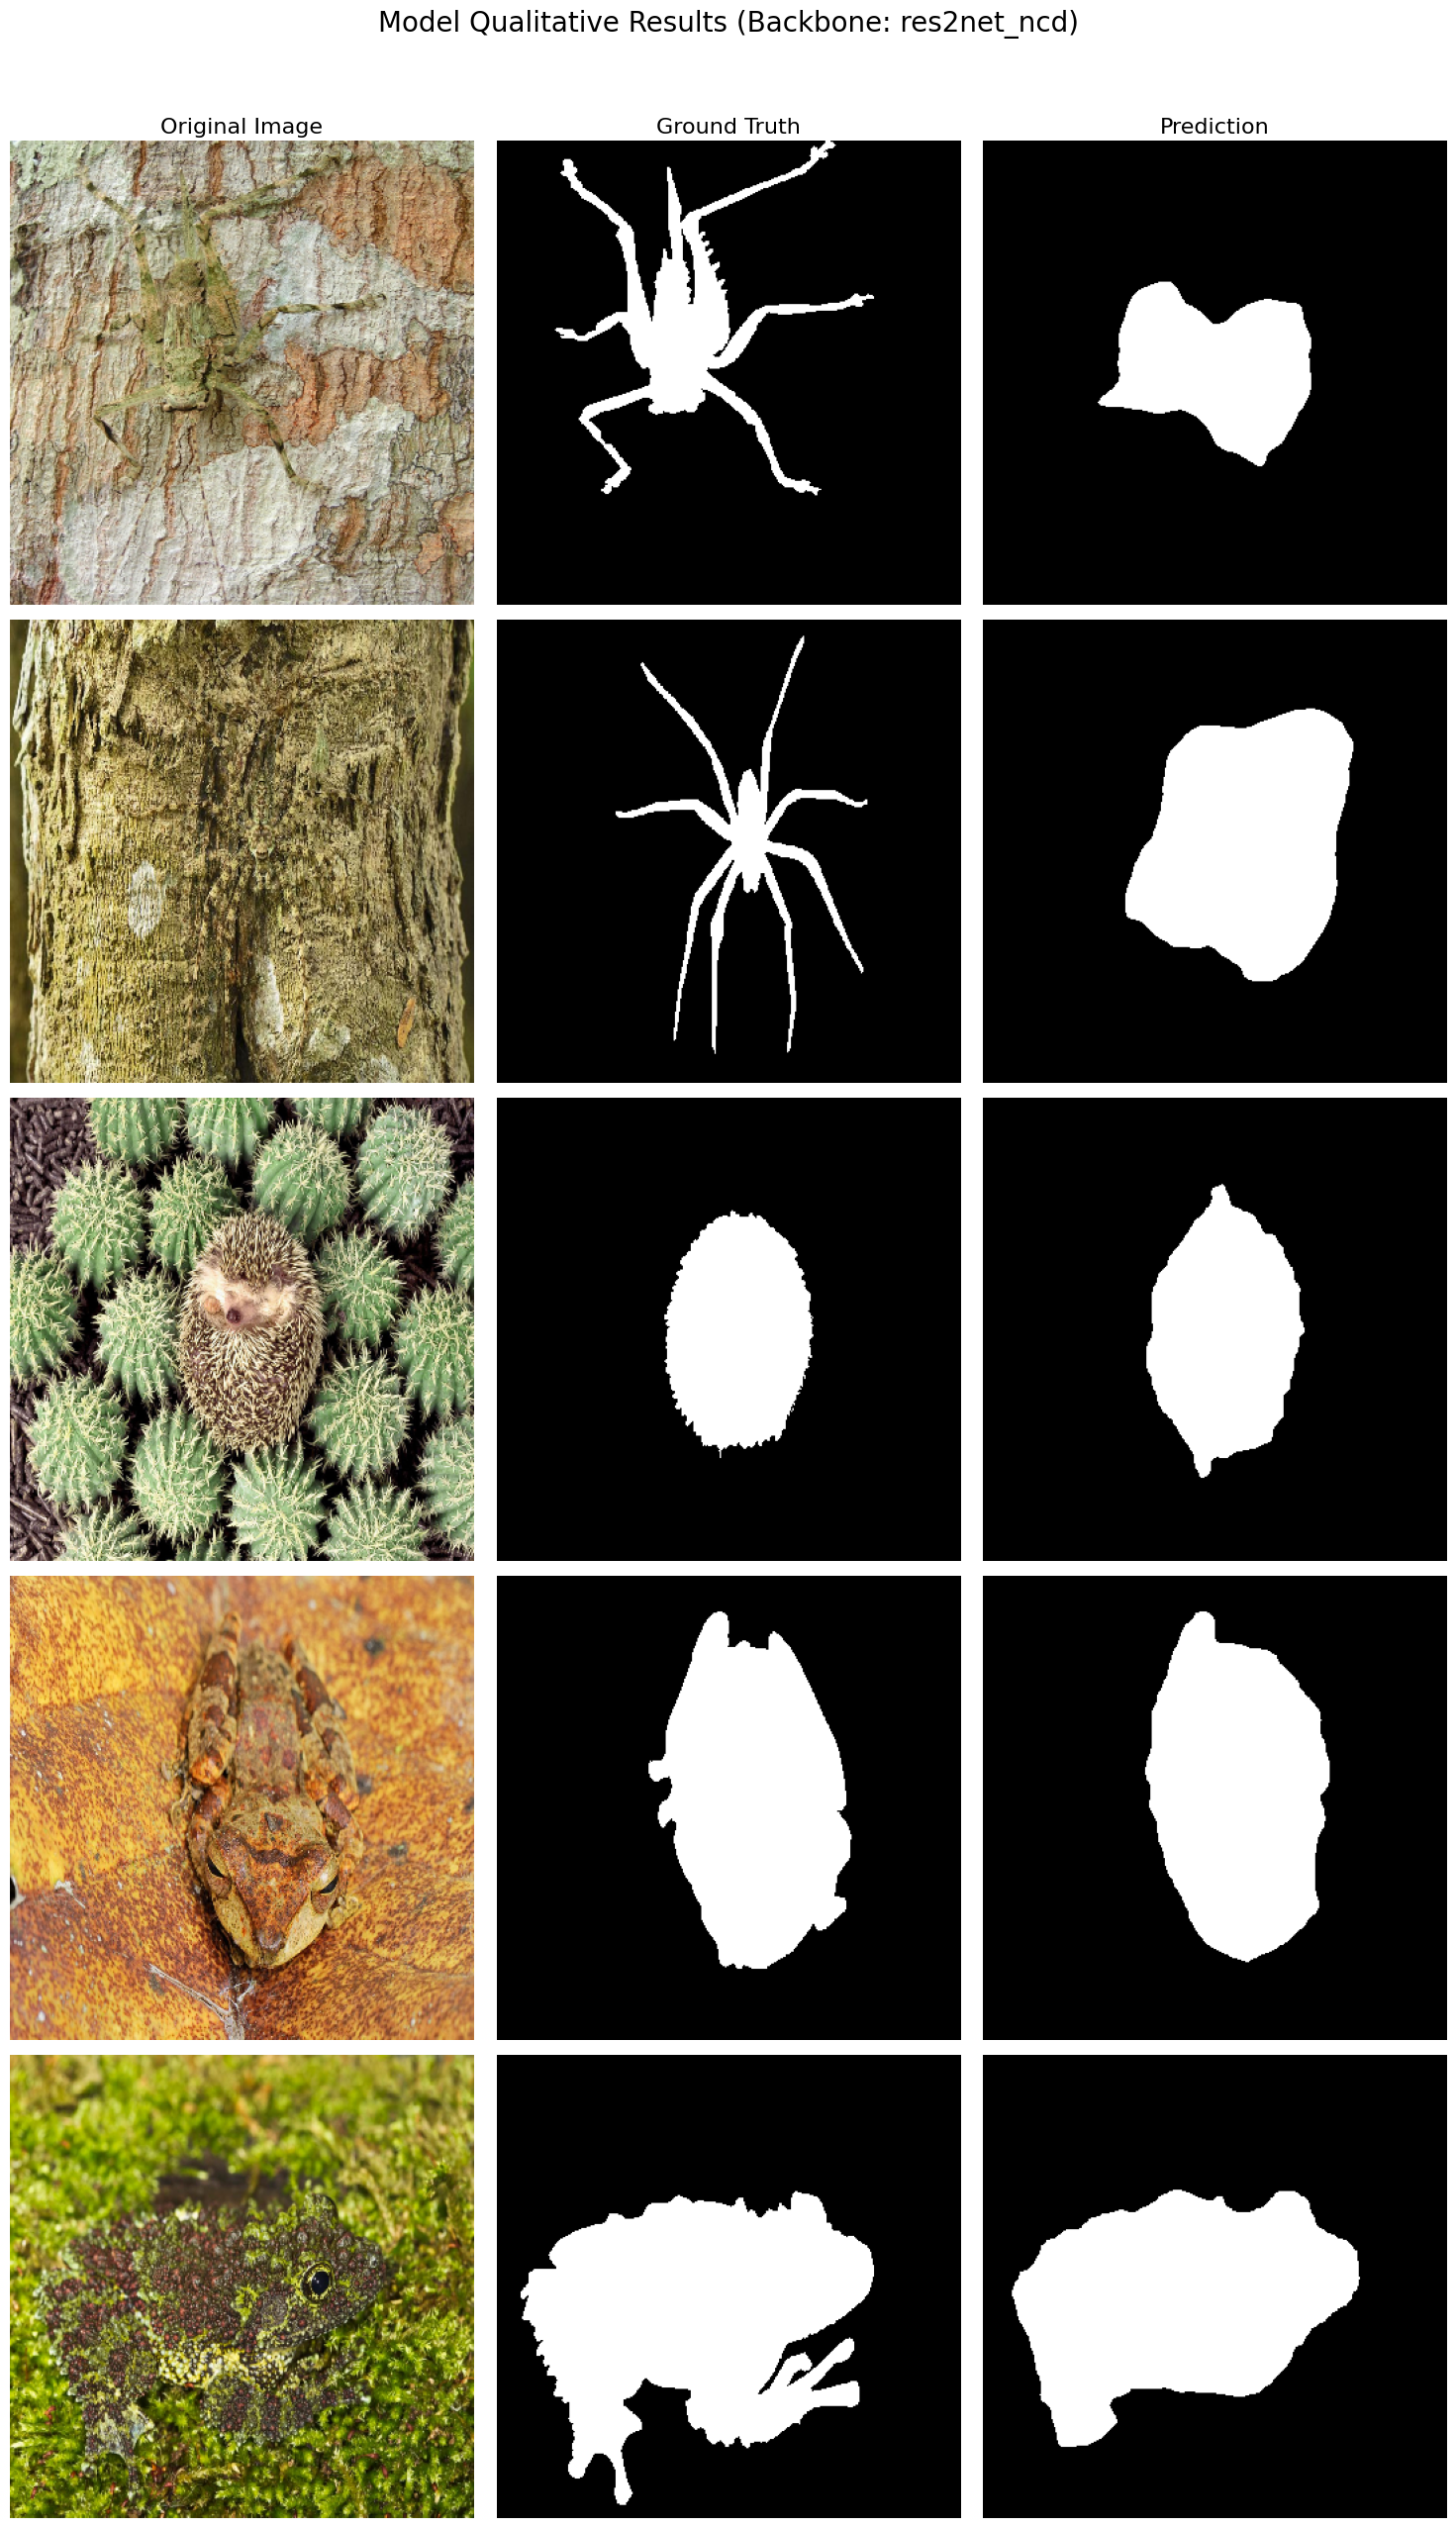

In [1]:
import torch
import cv2
import numpy as np
import matplotlib.pyplot as plt
import random
import os
import sys

# --- Add project root to Python path ---
PROJECT_ROOT = '/kaggle/working' 
sys.path.insert(0, PROJECT_ROOT)

from camoXpert.models.camoxpert import CamoXpert
from camoXpert.scripts.test import TestDataset # Re-use our smart TestDataset class

# --- Configuration (UPDATED FOR RESNET) ---
MODEL_PATH = "/kaggle/working/camoXpert/results/resnet_checkpoints/best_model.pth"
BACKBONE_NAME = "res2net_ncd" # <-- UPDATED
DATASET_PATH = "/kaggle/working/TestDataset/COD-TestDataset/CHAMELEON"
IMG_SIZE = 352
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# --- Load Model ---
print("Loading RESNET model for visualization...")
model = CamoXpert(backbone=BACKBONE_NAME, pretrained=False).to(DEVICE)
checkpoint = torch.load(MODEL_PATH, map_location=DEVICE)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()
print("Model loaded.")

# --- Load Dataset ---
dataset = TestDataset(root_dir=DATASET_PATH, img_size=IMG_SIZE)
# Get 5 random images
random_indices = random.sample(range(len(dataset)), 5)

# --- Create Plot ---
fig, axes = plt.subplots(5, 3, figsize=(15, 25))
fig.suptitle(f"Model Qualitative Results (Backbone: {BACKBONE_NAME})", fontsize=20, y=1.02)
axes[0, 0].set_title("Original Image", fontsize=16)
axes[0, 1].set_title("Ground Truth", fontsize=16)
axes[0, 2].set_title("Prediction", fontsize=16)

with torch.no_grad():
    for i, idx in enumerate(random_indices):
        # 1. Get data
        image_tensor, mask_tensor = dataset[idx]
        image_tensor = image_tensor.to(DEVICE).unsqueeze(0) # Add batch dim

        # 2. Run prediction
        pred_tensor, _, _ = model(image_tensor, return_deep_supervision=False)
        pred_mask = torch.sigmoid(pred_tensor).cpu().numpy().squeeze()
        pred_mask = (pred_mask > 0.5).astype(np.uint8)

        # 3. Get original image for plotting (un-normalize)
        img_name = dataset.image_list[idx]
        original_image = cv2.imread(os.path.join(dataset.image_dir, img_name))
        original_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)
        original_image = cv2.resize(original_image, (IMG_SIZE, IMG_SIZE))
        
        # 4. Get ground truth mask
        ground_truth_mask = mask_tensor.cpu().numpy().squeeze()

        # 5. Plot
        axes[i, 0].imshow(original_image)
        axes[i, 0].axis('off')
        axes[i, 1].imshow(ground_truth_mask, cmap='gray')
        axes[i, 1].axis('off')
        axes[i, 2].imshow(pred_mask, cmap='gray')
        axes[i, 2].axis('off')

plt.tight_layout()
plt.show()

# Block 17: Add the Rest2Net model files

In [ ]:
# Create the 'lib' directory if it doesn't exist
!mkdir -p /kaggle/working/camoXpert/lib

In [ ]:
%%writefile /kaggle/working/camoXpert/lib/Res2Net_v1b.py
import torch.nn as nn
import math
import torch.utils.model_zoo as model_zoo
import torch

model_urls = {
    'res2net50_v1b_26w_4s': 'https://shanghuagao.oss-cn-beijing.aliyuncs.com/res2net/res2net50_v1b_26w_4s-3cf99910.pth',
}

class Bottle2neck(nn.Module):
    expansion = 4
    def __init__(self, inplanes, planes, stride=1, downsample=None, baseWidth=26, scale=4, stype='normal'):
        super(Bottle2neck, self).__init__()
        width = int(math.floor(planes * (baseWidth / 64.0)))
        self.conv1 = nn.Conv2d(inplanes, width * scale, 1, bias=False)
        self.bn1 = nn.BatchNorm2d(width * scale)
        
        self.nums = scale - 1
        if stype == 'stage':
            self.pool = nn.AvgPool2d(3, stride=stride, padding=1)
        convs, bns = [], []
        for i in range(self.nums):
            convs.append(nn.Conv2d(width, width, 3, stride=stride, padding=1, bias=False))
            bns.append(nn.BatchNorm2d(width))
        self.convs = nn.ModuleList(convs)
        self.bns = nn.ModuleList(bns)

        self.conv3 = nn.Conv2d(width * scale, planes * self.expansion, 1, bias=False)
        self.bn3 = nn.BatchNorm2d(planes * self.expansion)

        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stype = stype
        self.scale = scale
        self.width = width

    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        spx = torch.split(out, self.width, 1)
        for i in range(self.nums):
            if i == 0 or self.stype == 'stage':
                sp = spx[i]
            else:
                sp = sp + spx[i]
            sp = self.convs[i](sp)
            sp = self.relu(self.bns[i](sp))
            out = sp if i == 0 else torch.cat((out, sp), 1)
        
        if self.scale != 1:
            if self.stype == 'normal':
                out = torch.cat((out, spx[self.nums]), 1)
            elif self.stype == 'stage':
                out = torch.cat((out, self.pool(spx[self.nums])), 1)

        out = self.conv3(out)
        out = self.bn3(out)
        if self.downsample is not None:
            residual = self.downsample(x)
        out += residual
        return self.relu(out)

class Res2Net(nn.Module):
    def __init__(self, block, layers, baseWidth=26, scale=4, num_classes=1000):
        self.inplanes = 64
        super(Res2Net, self).__init__()
        self.baseWidth = baseWidth
        self.scale = scale
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 32, 3, 2, 1, bias=False),
            nn.BatchNorm2d(32), nn.ReLU(inplace=True),
            nn.Conv2d(32, 32, 3, 1, 1, bias=False),
            nn.BatchNorm2d(32), nn.ReLU(inplace=True),
            nn.Conv2d(32, 64, 3, 1, 1, bias=False)
        )
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(3, 2, 1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.AvgPool2d(stride, stride, ceil_mode=True, count_include_pad=False),
                nn.Conv2d(self.inplanes, planes * block.expansion, 1, 1, bias=False),
                nn.BatchNorm2d(planes * block.expansion),
            )
        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample, stype='stage', baseWidth=self.baseWidth, scale=self.scale))
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes, baseWidth=self.baseWidth, scale=self.scale))
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x_start_pool = self.maxpool(x)
        x1 = self.layer1(x_start_pool)
        x2 = self.layer2(x1)
        x3 = self.layer3(x2)
        x4 = self.layer4(x3)
        return x1, x2, x3, x4

def res2net50_v1b_26w_4s(pretrained=False, **kwargs):
    model = Res2Net(Bottle2neck, [3, 4, 6, 3], baseWidth=26, scale=4, **kwargs)
    if pretrained:
        print("Loading Res2Net50 weights...")
        state_dict = model_zoo.load_url(model_urls['res2net50_v1b_26w_4s'], map_location='cpu')
        model.load_state_dict(state_dict, strict=False)
    return model

In [ ]:
%%writefile /kaggle/working/camoXpert/lib/Network_Res2Net_GRA_NCD.py
import torch
import torch.nn as nn
import torch.nn.functional as F
from camoXpert.lib.Res2Net_v1b import res2net50_v1b_26w_4s

class BasicConv2d(nn.Module):
    def __init__(self, in_planes, out_planes, kernel_size, stride=1, padding=0, dilation=1):
        super(BasicConv2d, self).__init__()
        self.conv = nn.Conv2d(in_planes, out_planes, kernel_size, stride, padding, dilation, bias=False)
        self.bn = nn.BatchNorm2d(out_planes)
        self.relu = nn.ReLU(inplace=True)
    def forward(self, x):
        return self.relu(self.bn(self.conv(x)))

class RFB_modified(nn.Module):
    def __init__(self, in_channel, out_channel): super(RFB_modified, self).__init__()
    def forward(self, x): return x

class NeighborConnectionDecoder(nn.Module):
    def __init__(self, channel): super(NeighborConnectionDecoder, self).__init__()
    def forward(self, x1, x2, x3): pass

class Network(nn.Module):
    def __init__(self, channel=32, imagenet_pretrained=True):
        super(Network, self).__init__()
        self.resnet = res2net50_v1b_26w_4s(pretrained=imagenet_pretrained)
    def forward(self, x):
        x_start = self.resnet.conv1(x)
        x_start = self.resnet.bn1(x_start)
        x_start = self.resnet.relu(x_start)
        x_start_pool = self.resnet.maxpool(x_start) 
        x1 = self.resnet.layer1(x_start_pool)
        x2 = self.resnet.layer2(x1)
        x3 = self.resnet.layer3(x2)
        x4 = self.resnet.layer4(x3)
        return x1, x2, x3, x4

In [ ]:
%%writefile /kaggle/working/camoXpert/models/sinet_encoder.py
import torch
import torch.nn as nn
import sys
import os
from camoXpert.lib.Network_Res2Net_GRA_NCD import Network as SINet_Network

class SINetEncoder(nn.Module):
    def __init__(self, pretrained=True):
        super().__init__()
        self.backbone = SINet_Network(imagenet_pretrained=pretrained)
        
        self.feature_info = [
            {'num_chs': 256, 'reduction': 4, 'module': 'layer1'},
            {'num_chs': 512, 'reduction': 8, 'module': 'layer2'},
            {'num_chs': 1024, 'reduction': 16, 'module': 'layer3'},
            {'num_chs': 2048, 'reduction': 32, 'module': 'layer4'}
        ]

    def forward(self, x):
        return self.backbone(x)

    def channels(self):
        return [info['num_chs'] for info in self.feature_info]